In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib
from matplotlib.pyplot import figure
matplotlib.rc('figure', figsize=(6, 6))

In [2]:
SQUARE_TOLERANCE = 0.15
WARP_DIM = 300

In [3]:
def count_children(hierarchy, parent, inner=False):
    if parent == -1:
        return 0
    elif not inner:
        return count_children(hierarchy, hierarchy[parent][2], True)
    return 1 + count_children(hierarchy, hierarchy[parent][0], True) + count_children(hierarchy, hierarchy[parent][2], True)


def has_square_parent(hierarchy, squares, parent):
    if hierarchy[parent][3] == -1:
        return False
    if hierarchy[parent][3] in squares:
        return True
    return has_square_parent(hierarchy, squares, hierarchy[parent][3])


def get_center(c):
    m = cv2.moments(c)
    return [int(m["m10"] / m["m00"]), int(m["m01"] / m["m00"])]



In [4]:
class Square:
    def __init__(self, index, contour):
        self.index = index
        self.contour = contour
        self.area = cv2.contourArea(contour)
        self.center = get_center(contour)
        self.peri = cv2.arcLength(contour, True)

![title](content/flow.png)

In [5]:
img = cv2.imread('images/004.jpg')

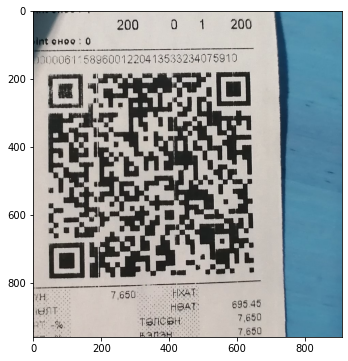

In [6]:
plt.imshow(img)

In [7]:
blank_imgs = []
for i in range(10):
    blank_imgs.append(np.zeros(img.shape, np.uint8))

In [8]:
# Otsu's thresholding after Gaussian filtering
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(7,7),0)
ret3, th = cv2.threshold(blur,0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
edged = cv2.Canny(th, 20, 150)

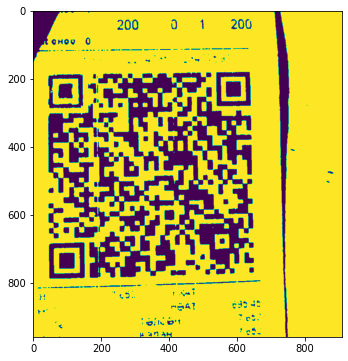

In [9]:
plt.imshow(th)

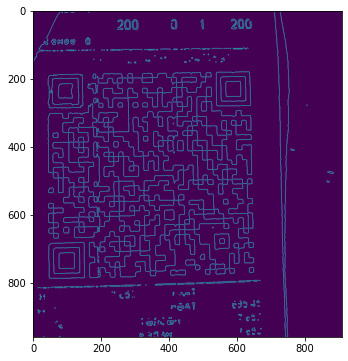

In [10]:
plt.imshow(edged)

In [11]:
contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

![title](content/contour.png)

In [12]:
len(contours)

555

In [13]:
for c in contours:
    cv2.drawContours(blank_imgs[0], [c], 0, (255,255,255), 3)

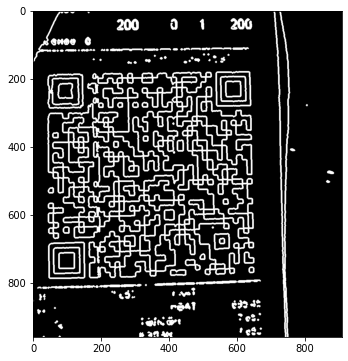

In [14]:
plt.imshow(blank_imgs[0])

In [15]:
for c in contours:
    # Approximate the contour
    peri = cv2.arcLength(c, True)
    area = cv2.contourArea(c)
    approx = cv2.approxPolyDP(c, 0.03 * peri, True)
    cv2.drawContours(blank_imgs[1], [approx], 0, (255,255,255), 3)

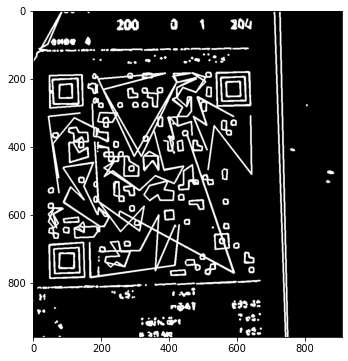

In [16]:
plt.imshow(blank_imgs[1])

In [17]:
square_indices = []
squares = []
index = -1
for c in contours:
    # Approximate the contour
    peri = cv2.arcLength(c, True)
    area = cv2.contourArea(c)
    approx = cv2.approxPolyDP(c, 0.03 * peri, True)
    index += 1

    # Find all quadrilateral contours
    if len(approx) != 4:
        cv2.drawContours(blank_imgs[2], [approx], 0, (255,255,255), 3)
        continue
        
    # area filter
    if area <= 25:
        cv2.drawContours(blank_imgs[3], [approx], 0, (255,255,255), 3)
        continue
    
    # check quadrilateral
    ratio = math.fabs((peri / 4) ** 2) / area
    if (1 - SQUARE_TOLERANCE >= ratio) or (ratio >= 1 + SQUARE_TOLERANCE):
        cv2.drawContours(blank_imgs[4], [approx], 0, (255,255,255), 3)
        continue
    
    # must have sub contours 
    if (count_children(hierarchy[0], index) < 2):
        cv2.drawContours(blank_imgs[5], [approx], 0, (255,255,255), 3)
        continue
    
    # check root contours
    if has_square_parent(hierarchy[0], square_indices, index) == False:
        squares.append(Square(index, approx))
        square_indices.append(index)
        cv2.drawContours(blank_imgs[6], [approx], 0, (255,255,255), 3)
    #cv2.drawContours(blank_imgs[7], [approx], 0, (255,255,255), 3)

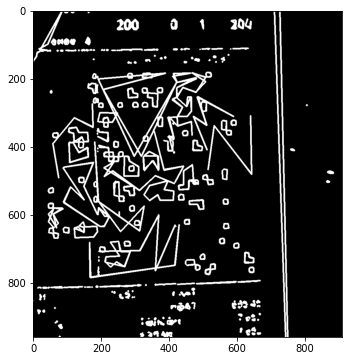

In [18]:
plt.imshow(blank_imgs[2])

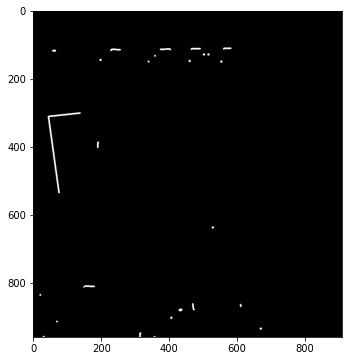

In [19]:
plt.imshow(blank_imgs[3])

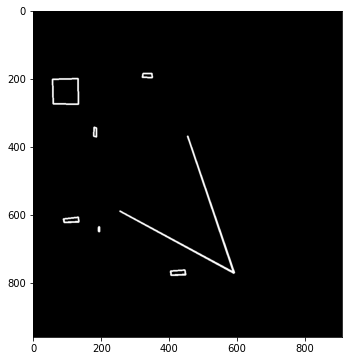

In [20]:
plt.imshow(blank_imgs[4])

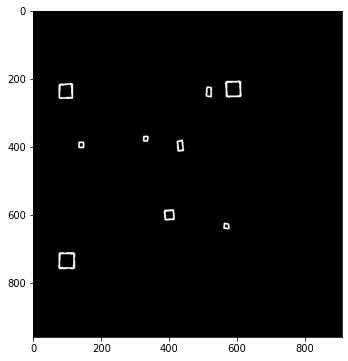

In [21]:
plt.imshow(blank_imgs[5])

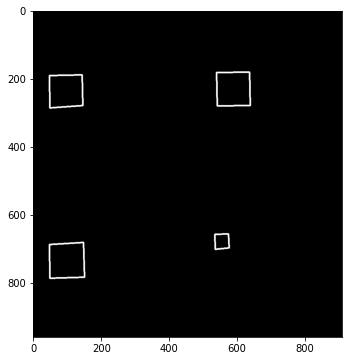

In [22]:
plt.imshow(blank_imgs[6])

In [23]:
#plt.imshow(blank_imgs[7])

![title](content/flow.png)

In [24]:
similar = {}
rectangles = []
for square1, square2 in list(combinations(squares, 2)):
    ratio = square1.area/square2.area
    print(ratio)
    if 0.8 < ratio < 1.2:
        if square1.index not in similar:
            similar[square1.index] = square1
        if square2.index not in similar:
            similar[square2.index] = square2

5.889565217391304
1.137299899249972
1.0685212452671435
0.19310422030672786
0.18142616743794698
0.9395246108540176


In [25]:
a = list(similar.values())[0].contour

In [26]:
b = list(similar.values())[1].contour

In [27]:
c = list(similar.values())[2].contour

In [28]:
total_squares = None

In [29]:
np.concatenate((a, b, c), axis=0)

array([[[148, 682]],

       [[ 48, 688]],

       [[ 49, 787]],

       [[151, 784]],

       [[ 48, 192]],

       [[ 49, 287]],

       [[146, 280]],

       [[144, 190]],

       [[636, 182]],

       [[539, 183]],

       [[541, 281]],

       [[638, 280]]], dtype=int32)

In [30]:
total_squares = np.concatenate((a, b, c), axis=0)

In [31]:
hull = cv2.convexHull(total_squares)

In [32]:
#plt.imshow(hull)

In [33]:
ret = cv2.drawContours(blank_imgs[7], [hull], 0, (255,255,255),3)

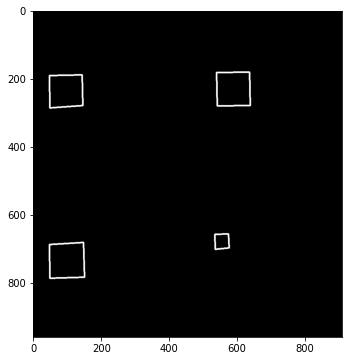

In [34]:
plt.imshow(blank_imgs[6])

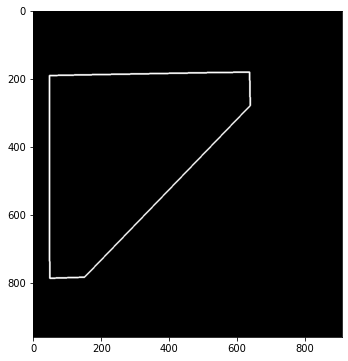

In [35]:
plt.imshow(blank_imgs[7])

In [36]:
orig = img.copy()
rect = cv2.minAreaRect(total_squares)
box = cv2.boxPoints(rect)
box = np.int0(box)
ret = cv2.drawContours(orig,[box],0,(0,255,0),3)

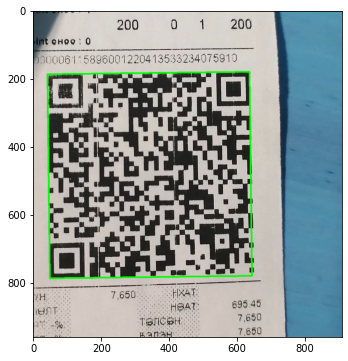

In [37]:
plt.imshow(orig)

In [38]:
box

array([[ 42, 188],
       [636, 181],
       [643, 780],
       [ 49, 787]])

In [39]:
dst = np.array([
    [0, 0],
    [WARP_DIM - 1, 0],
    [WARP_DIM - 1, WARP_DIM - 1],
    [0, WARP_DIM - 1]], dtype="float32")

In [40]:
dst

array([[  0.,   0.],
       [299.,   0.],
       [299., 299.],
       [  0., 299.]], dtype=float32)

In [41]:
warp = cv2.warpPerspective(img, cv2.getPerspectiveTransform(box.astype(np.float32), dst), (WARP_DIM, WARP_DIM))

![title](content/perspective1.png)

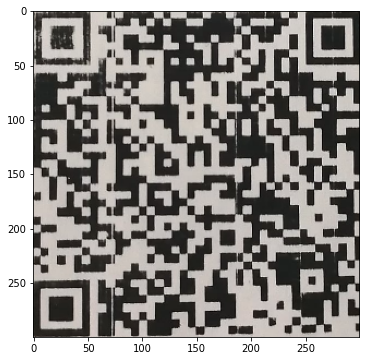

In [42]:
plt.imshow(warp)